In [1]:
#Installing the required libraries
!pip install pandas
!pip install folium




You should consider upgrading via the 'c:\users\v\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\v\anaconda3\python.exe -m pip install --upgrade pip' command.


#### INSTALLING THE RELEVANT LIBRARIES

In [2]:
#import the required libraries
import pandas as pd # Library for analysing the data
from geopy.geocoders import Nominatim # Converting address into latitude and longitude values
import folium # for MAPS
import geocoder # For Nominatim
import requests 
from pandas.io.json import json_normalize
import numpy as np # library to handle data 
#matplot used to plotting the data
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans # used for clustering 
# for elbow method of K-Means
from sklearn import metrics 
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt  

## TRACING VICINITY OF AREAS CLOSEST TO CBD
   Before tracing the areas around the CBD we need need to get the location of the Melbourne CBD. We use Nominatim to get the geographical coordinates for Melbourne CBD

In [4]:
address = 'La Trobe St &, Swanston St, Melbourne VIC 3000'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Melbourne CBD are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of Melbourne CBD are -37.81007715, 144.9641385456694.


#### Since this is a huge dataset, we have certain restrains around the use of Foursqaure API and Folium. We therefore selected the closest 88 suburbs from the Melbourne Central Business District. These selected suburbs are within the 10km range of the CBD

In [5]:
df = pd.read_csv("Aus_Vict.csv")
df.drop("State",axis=1,inplace=True)
df.head()


,Postcode,Suburb,Lat,Lon
0,3003,WEST MELBOURNE,-37.806255,144.941123
1,3006,SOUTHBANK,-37.823258,144.965926
2,3008,DOCKLANDS,-37.814719,144.948039
3,3011,FOOTSCRAY,-37.799770,144.899587
4,3011,SEDDON,-37.808769,144.895486


   ## Melbourne CBD
   #### Plotting the Melbourne CBD using the coordinated obtained from Nominatim.The CBD is not a specific point but a range around the city covering a total area of 2489.97 meters. For more info check - https://en.wikipedia.org/wiki/Melbourne_city_centre

In [6]:
map_melbourne = folium.Map([-37.81007715, 144.9641385456694], zoom_start=15)
folium.Circle(
    radius=2489,
    location=[-37.81007715, 144.9641385456694],
    popup='Melbourne CBD',
    color='crimson',
    fill=True,
).add_to(map_melbourne)
map_melbourne

# Mapping the Suburbs



In [7]:
map = folium.Map(location=[-37.81007715, 144.9641385456694], zoom_start=12)
locations = list (zip(df.Lat, df.Lon))
icons = [folium.Icon(icon="cloud", prefix="fa") for _ in range(len(locations))]
for Lat, Lon, Suburb, Postcode in zip(df['Lat'], df['Lon'],df['Suburb'], df['Postcode']): 
    label = '{}, {}'.format(Postcode,Suburb)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
            [Lat, Lon],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_melbourne) 

map_melbourne  

 ### Locations closest to the Central Business District(<5 km) are taken into consideration 
  ##### One of the criteria is that the new location should be within a 5km radius. Here we use the circle which contains the "covered area" representing the suburbs within 5km range.

In [8]:
map_melbourne = folium.Map([-37.81007715, 144.9641385456694], zoom_start=15)
folium.Circle(
    radius=2489,
    location=[-37.81007715, 144.9641385456694],
    popup='Melbourne CBD',
    color='crimson',
    fill=True,
).add_to(map_melbourne)
map_melbourne
folium.Circle(
    radius=5000,
    location=[-37.81007715, 144.9641385456694],
    popup='Covered Area',
    color='yellow',
    fill=True,
).add_to(map_melbourne)
map_melbourne
map = folium.Map(location=[-37.81007715, 144.9641385456694], zoom_start=12)
locations = list(zip(df.Lat, df.Lon))
icons = [folium.Icon(icon="cloud", prefix="fa") for _ in range(len(locations))]

for Lat, Lon, Suburb, Postcode in zip(df['Lat'], df['Lon'], df['Suburb'], df['Postcode']):
    label = '{}, {}'.format(Suburb, Postcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [Lat, Lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_melbourne) 


map_melbourne  


# Leveraging Foursquare API

### Defining Foursquare API

#### Client id and secret removed due to privacy purposes

## Venues within 5km range 

In [10]:
LIMIT = 100
radius = 5000
venues_list = []
for Lat, Lon, Suburb, Postcode in zip(df['Lat'], df['Lon'], df['Suburb'], df['Postcode']):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
     CLIENT_ID, 
     CLIENT_SECRET, 
      VERSION, 
      Lat, 
      Lon, 
      radius, 
      LIMIT)
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues_list.append((
            Suburb,
            Lat, 
            Lon, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))


### Getting venues from all the suburbs

In [11]:
#Coverting list into a new dataframe
venues_df = pd.DataFrame(venues_list)
#defining the column names
venues_df.columns = ['Suburb', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']
venues_df.head()

,Suburb,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,WEST MELBOURNE,-37.806255,144.941123,Twenty & Six Espresso,-37.802773,144.947505,Café
1,WEST MELBOURNE,-37.806255,144.941123,Beatrix,-37.802407,144.944459,Café
2,WEST MELBOURNE,-37.806255,144.941123,Di Bella Roasting Warehouse,-37.804496,144.950684,Café
3,WEST MELBOURNE,-37.806255,144.941123,The French Quarter,-37.802822,144.948299,Café
4,WEST MELBOURNE,-37.806255,144.941123,Auction Rooms,-37.802507,144.949560,Café


In [12]:
#Checking number of venues for each suburb
venues_df.groupby(["Suburb"]).count()        

,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
Suburb,,,,,,
ABBOTSFORD,100,100,100,100,100,100
ABERFELDIE,100,100,100,100,100,100
ALBERT PARK,100,100,100,100,100,100
ALPHINGTON,100,100,100,100,100,100
ARMADALE NORTH,100,100,100,100,100,100
ASCOT VALE,100,100,100,100,100,100
BALACLAVA,100,100,100,100,100,100
BALWYN,100,100,100,100,100,100
BALWYN NORTH,100,100,100,100,100,100


In [13]:
#Unique categories curated from all the returned venues
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 212 uniques categories.


In [14]:
#list of categories 
venues_df['VenueCategory'].unique()[:54]

array(['Café', 'Park', 'Coffee Shop', 'Market', 'Thai Restaurant',
       'Mini Golf', 'Night Market', 'Donut Shop', 'Gym / Fitness Center',
       'Playground', 'Korean Restaurant', 'Bookstore', 'Burger Joint',
       'Italian Restaurant', 'Wine Bar', 'Japanese Restaurant',
       'Mexican Restaurant', 'Library', 'Whisky Bar', 'Bar',
       'Cocktail Bar', 'Dessert Shop', 'General Entertainment',
       'French Restaurant', 'Shopping Mall', 'Ice Cream Shop',
       'Beer Garden', 'Plaza', 'Brazilian Restaurant', 'Road',
       'Asian Restaurant', 'Comic Shop', 'Pedestrian Plaza',
       'Frozen Yogurt Shop', 'Creperie', 'Deli / Bodega', 'Pizza Place',
       'Tea Room', 'Lounge', 'Theater', 'Hotel', 'Australian Restaurant',
       'Museum', 'Street Art', 'Vietnamese Restaurant',
       'Monument / Landmark', 'Boutique', 'River', 'Bakery', 'Speakeasy',
       'Cheese Shop', 'Argentinian Restaurant', 'Performing Arts Venue',
       'Art Gallery'], dtype=object)

In [15]:
#Filtering of Vietnamese Restaurants
"Vietnamese Restaurant" in venues_df['VenueCategory'].unique()

True

# Analysing Each Suburb

In [16]:
df_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_onehot['Suburbs'] = venues_df['Suburb'] 

# move neighborhood column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

#print(kl_onehot.shape)
df_onehot.head()


,Suburbs,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo,Zoo Exhibit
0,WEST MELBOURNE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,WEST MELBOURNE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,WEST MELBOURNE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,WEST MELBOURNE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,WEST MELBOURNE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Grouping the rows by suburbs by taking the means of the frequency of occurrence of each category

In [17]:
df_grouped = df_onehot.groupby(["Suburbs"]).mean().reset_index()

print(df_grouped.shape)
df_grouped

(84, 213)


,Suburbs,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo,Zoo Exhibit
0,ABBOTSFORD,0.000000,0.00,0.00,0.00,0.00,0.010,0.00,0.00,0.020000,...,0.000,0.000,0.040,0.020000,0.02,0.050,0.010000,0.000000,0.000,0.000
1,ABERFELDIE,0.000000,0.00,0.01,0.00,0.00,0.000,0.00,0.02,0.010000,...,0.010,0.000,0.000,0.030000,0.00,0.000,0.000000,0.000000,0.000,0.000
2,ALBERT PARK,0.000000,0.00,0.00,0.00,0.00,0.000,0.02,0.00,0.020000,...,0.000,0.000,0.000,0.010000,0.01,0.020,0.000000,0.000000,0.000,0.000
3,ALPHINGTON,0.000000,0.00,0.00,0.00,0.00,0.000,0.00,0.00,0.000000,...,0.000,0.000,0.040,0.020000,0.00,0.020,0.000000,0.000000,0.000,0.000
4,ARMADALE NORTH,0.000000,0.00,0.00,0.00,0.00,0.010,0.01,0.00,0.010000,...,0.000,0.000,0.010,0.030000,0.01,0.010,0.000000,0.000000,0.000,0.000
5,ASCOT VALE,0.000000,0.00,0.00,0.00,0.00,0.000,0.00,0.00,0.010000,...,0.010,0.000,0.000,0.040000,0.00,0.010,0.010000,0.000000,0.010,0.020
6,BALACLAVA,0.000000,0.00,0.00,0.00,0.00,0.000,0.00,0.00,0.010000,...,0.000,0.000,0.030,0.010000,0.00,0.010,0.000000,0.010000,0.000,0.000
7,BALWYN,0.010000,0.00,0.00,0.00,0.00,0.000,0.00,0.00,0.020000,...,0.000,0.000,0.000,0.020000,0.00,0.000,0.010000,0.000000,0.000,0.000
8,BALWYN NORTH,0.010000,0.00,0.00,0.00,0.00,0.000,0.01,0.00,0.010000,...,0.000,0.000,0.000,0.000000,0.00,0.000,0.010000,0.000000,0.000,0.000
9,BRUNSWICK,0.000000,0.00,0.00,0.00,0.00,0.005,0.00,0.00,0.005000,...,0.005,0.005,0.025,0.010000,0.01,0.025,0.005000,0.000000,0.005,0.025


In [18]:
len(df_grouped[df_grouped["Vietnamese Restaurant"] > 0])

63

### New Dataframe for Vietnamese Restaurant only

In [38]:
viet_res = df_grouped[["Suburbs","Vietnamese Restaurant"]]
viet_res.head()

,Suburbs,Vietnamese Restaurant
0,ABBOTSFORD,0.02
1,ABERFELDIE,0.03
2,ALBERT PARK,0.01
3,ALPHINGTON,0.02
4,ARMADALE NORTH,0.03



## Calculating the optimal number of clusters for the data using the elbow method

In [ ]:
inertias = [] 
mapping2 = {} 
K = range(1,10) 
for k in K: 
#Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(viet_res) 
    kmeanModel.fit(viet_res) 
    inertias.append(kmeanModel.inertia_)  
    mapping2[k] = kmeanModel.inertia_

In [40]:
for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val))

In [ ]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method') 
plt.show()

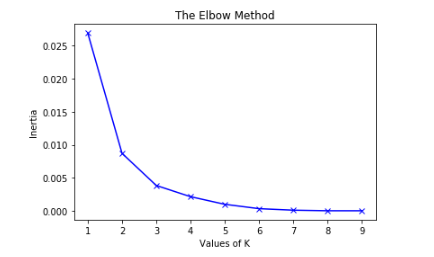

To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the inertia start decreasing in a linear fashion. Thus for the given data, we conclude that the optimal number of clusters for the data is 3.

## Clustering the Suburbs into 3 clusters using K-Means.

In [46]:
#Number of clusters
kclusters = 3

kl_clustering = viet_res.drop(["Suburbs"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kl_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 0, 2, 2, 2, 0, 2, 0, 0])

In [47]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
df_merged = viet_res.copy()

# add clustering labels
df_merged["Cluster Labels"] = kmeans.labels_

In [48]:
#sorting the result by cluster label
df_merged.head()

,Suburbs,Vietnamese Restaurant,Cluster Labels
0,ABBOTSFORD,0.02,2
1,ABERFELDIE,0.03,2
2,ALBERT PARK,0.01,0
3,ALPHINGTON,0.02,2
4,ARMADALE NORTH,0.03,2


In [49]:
df_merged.rename(columns={"Suburbs": "Suburb"}, inplace=True)
df_merged.head()

,Suburb,Vietnamese Restaurant,Cluster Labels
0,ABBOTSFORD,0.02,2
1,ABERFELDIE,0.03,2
2,ALBERT PARK,0.01,0
3,ALPHINGTON,0.02,2
4,ARMADALE NORTH,0.03,2


In [50]:
# merge df_merged dataset with df dataset to add latitude/longitude for each neighborhood
df_merged = pd.merge(df_merged,df,on='Suburb')

print(df_merged.shape)
df_merged.head()

(87, 6)


,Suburb,Vietnamese Restaurant,Cluster Labels,Postcode,Lat,Lon
0,ABBOTSFORD,0.02,2,3067,-37.801781,144.998752
1,ABERFELDIE,0.03,2,3040,-37.756690,144.896259
2,ALBERT PARK,0.01,0,3206,-37.840705,144.955710
3,ALPHINGTON,0.02,2,3078,-37.780767,145.031160
4,ARMADALE NORTH,0.03,2,3143,-37.828845,145.007261


In [51]:
#sorting results by checking cluster label
df_merged.sort_values(["Cluster Labels"], inplace=True)
df_merged


,Suburb,Vietnamese Restaurant,Cluster Labels,Postcode,Lat,Lon
43,IVANHOE,0.01,0,8576,-37.764016,145.044798
28,ELSTERNWICK,0.01,0,3185,-37.884724,145.004153
29,ELWOOD,0.01,0,3184,-37.888121,144.985026
31,ESSENDON WEST,0.00,0,3040,-37.753802,144.888271
67,RIPPONLEA,0.01,0,3185,-37.876692,144.996194
34,FITZROY NORTH,0.01,0,3068,-37.783400,144.984688
35,FLEMINGTON,0.01,0,3031,-37.788375,144.931472
65,PRINCES HILL,0.00,0,3054,-37.780995,144.962792
37,GARDENVALE,0.01,0,3185,-37.896915,145.005249
38,GLEN IRIS,0.00,0,3146,-37.854687,145.067215


# Visualising the cluster
####   Cluster Zero are in  Red
####   Cluster One are in Blue
####   Cluster Two is in Green

In [52]:
map_clusters = folium.Map(location=[Lat, Lon], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Lat'], df_merged['Lon'], df_merged['Suburb'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

# Examining the clusters 

### Cluster 0

In [53]:
df_merged.loc[df_merged['Cluster Labels'] == 0]

,Suburb,Vietnamese Restaurant,Cluster Labels,Postcode,Lat,Lon
43,IVANHOE,0.010000,0,8576,-37.764016,145.044798
28,ELSTERNWICK,0.010000,0,3185,-37.884724,145.004153
29,ELWOOD,0.010000,0,3184,-37.888121,144.985026
31,ESSENDON WEST,0.000000,0,3040,-37.753802,144.888271
67,RIPPONLEA,0.010000,0,3185,-37.876692,144.996194
34,FITZROY NORTH,0.010000,0,3068,-37.783400,144.984688
35,FLEMINGTON,0.010000,0,3031,-37.788375,144.931472
65,PRINCES HILL,0.000000,0,3054,-37.780995,144.962792
37,GARDENVALE,0.010000,0,3185,-37.896915,145.005249
38,GLEN IRIS,0.000000,0,3146,-37.854687,145.067215


### Cluster 1

In [54]:
df_merged.loc[df_merged['Cluster Labels'] == 1]


,Suburb,Vietnamese Restaurant,Cluster Labels,Postcode,Lat,Lon
79,TOTTENHAM,0.08,1,3012,-37.799065,144.857829
68,SEDDON,0.05,1,3011,-37.808769,144.895486
81,WEST FOOTSCRAY,0.05,1,3012,-37.797701,144.879924
69,SOUTH KINGSVILLE,0.05,1,3015,-37.833627,144.870742
56,MOONEE PONDS,0.05,1,3039,-37.765707,144.919163
73,SPOTSWOOD,0.05,1,3015,-37.829670,144.885078
86,YARRAVILLE,0.06,1,3013,-37.816178,144.889774
50,MAIDSTONE,0.08,1,3012,-37.782096,144.874299
48,KINGSVILLE,0.05,1,3012,-37.812635,144.881803


### Cluster 2

In [55]:
df_merged.loc[df_merged['Cluster Labels'] == 2]

,Suburb,Vietnamese Restaurant,Cluster Labels,Postcode,Lat,Lon
1,ABERFELDIE,0.03,2,3040,-37.756690,144.896259
3,ALPHINGTON,0.02,2,3078,-37.780767,145.031160
4,ARMADALE NORTH,0.03,2,3143,-37.828845,145.007261
5,ASCOT VALE,0.04,2,3032,-37.775830,144.923377
7,BALWYN,0.02,2,3103,-37.809701,145.082303
11,BRUNSWICK EAST,0.02,2,3057,-37.764910,144.979567
12,BRUNSWICK WEST,0.02,2,3055,-37.762489,144.961176
77,THORNBURY,0.02,2,3071,-37.755040,144.998589
76,ST KILDA WEST,0.02,2,3182,-37.860901,144.972523
13,BURNLEY,0.03,2,3121,-37.826869,145.007098


### These are the areas which are within the 10 km radius of the CBD without a Vietnamese Restaurant

In [56]:
df_final = df_merged.loc[df_merged['Vietnamese Restaurant'] == 0.000]

In [57]:
df_final

,Suburb,Vietnamese Restaurant,Cluster Labels,Postcode,Lat,Lon
31,ESSENDON WEST,0.0,0,3040,-37.753802,144.888271
65,PRINCES HILL,0.0,0,3054,-37.780995,144.962792
38,GLEN IRIS,0.0,0,3146,-37.854687,145.067215
39,HAWTHORN,0.0,0,3122,-37.834855,145.052097
40,HAWTHORN,0.0,0,8622,-37.889860,145.021417
62,PORT MELBOURNE,0.0,0,3207,-37.975682,145.030468
44,IVANHOE EAST,0.0,0,3079,-37.772830,145.059401
60,PARKVILLE,0.0,0,3052,-37.788531,144.947731
58,NORTH MELBOURNE,0.0,0,3051,-37.905996,145.056254
52,MALVERN EAST,0.0,0,3145,-37.878370,145.067892


In [58]:
map_melbourne = folium.Map([Lat, Lon], zoom_start=15)
folium.Circle(
    radius=2489,
    location=[-37.81007715, 144.9641385456694],
    popup='Melbourne CBD',
    color='crimson',
    fill=True,
).add_to(map_melbourne)
map_melbourne
folium.Circle(
    radius=5000,
    location=[-37.81007715, 144.9641385456694],
    popup='Covered Area',
    color='yellow',
    fill=True,
).add_to(map_melbourne)
map_melbourne
map = folium.Map(location=[-37.81007715, 144.9641385456694], zoom_start=12)
locations = list(zip(df_final.Lat, df_final.Lon))
icons = [folium.Icon(icon="cloud", prefix="fa") for _ in range(len(locations))]

for Lat, Lon, Suburb, Postcode in zip(df_final['Lat'], df_final['Lon'], df_final['Suburb'], df_final['Postcode']):
    label = '{}, {}'.format(Suburb, Postcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [Lat, Lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_melbourne) 


map_melbourne  

## Results
This filtering of clusters has helped us narrows our search down from 88 suburbs to the 3 suburbs which we believe are the best location for opening a new Vietnamese restaurant taking all factors into consideration.


## The areas closest to the CBD and within the covered area are as follows
### 1 - Parkville.
### 2 - Princes Hill.
### 3 - Carlton North.


## Conclusion
Purpose of this project was to identify areas in Melbourne close to CBD (within 5km) with low to no Vietnamese restaurants to aid stakeholders in narrowing down the search for optimal location for a new Vietnamese restaurant. By using our primary data and the Foursquare data we have first identified the restaurants and venues according to their frequency of occurrence in each Suburb. Clustering of those locations was then performed to filter the data according to their frequencies and their distance from the CBD. The filtering of clusters has helped us narrows our search from 88 suburbs down to the 3 suburbs which we believe might be the best location for opening a new Vietnamese restaurant taking all other factors constant and considering the data limitation. However, final decision on optimal restaurant location will be made by stakeholders based on specific characteristics of suburbs and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to parking and train station), levels of noise / proximity to major roads, real estate availability and prices, social and economic dynamics of every suburb etc